In [155]:
import pandas as pd

df = pd.read_excel('../data/cleaned_v2.xlsx')
df = df.set_index('Department')

In [156]:
df.groupby(df.index).count()

,Description
Department,
Building Permission,2119
Drainage,2132
Electrical,4037
Encroachment,1470
Garbage,16932
Garden,1653
Health,2802
Property Tax,1491
Road,5510


In [157]:
df_for_training = pd.DataFrame()
SAMPLES = 4000
STATE = 0

In [158]:
for i in list(set(df.index)):
    df_for_training = df_for_training.append(df.loc[i].sample(n=SAMPLES,random_state=STATE,replace=True))

In [159]:
df_for_training['class_label'] = df_for_training.index.factorize()[0]

In [160]:
df_for_training

,Description,class_label
Department,,
Property Tax,nd May 17 To Pune Municipal Corporation Sub...,0
Property Tax,Avoid all Possible cyber attacks on the proper...,0
Property Tax,I am not getting the property tax transfer rec...,0
Property Tax,citizen la propety tax bill jast ala ahe......,0
Property Tax,last 5 year se ek hi property ke tax bill aa...,0
...,...,...
Garbage,Garbage dump,10
Garbage,Garbage dump,10
Garbage,Garbage vehicle not arrived,10


In [161]:
mapper = {}
for i,j in enumerate(list(set(df_for_training.index))):
    print(i,j)
    mapper[i] = j

0 Property Tax
1 Drainage
2 Building Permission
3 Garden
4 Stray Dogs
5 Encroachment
6 Water Supply
7 Health
8 Electrical
9 Road
10 Garbage


In [162]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/manpreet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [163]:
stemmer = PorterStemmer()
words = stopwords.words("english")
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True)

In [164]:
X = df_for_training.copy() # Deep copy
X.columns = ['text','label']
X.index.name = None
X = X.reset_index()
X = X[['text','label']]
X = X.sample(frac=1)

In [165]:
X

,text,label
7895,Drainage line choked up since 4days,1
22045,Encroachment on footpath,5
10245,Respected Sir I would like to bring your kind ...,2
18606,I am a resident of Tingre Nagar Lane no. 9. We...,4
1265,jast kar akarni babat,0
...,...,...
16479,Dear Sir - There are many stray dogs coming in...,4
21249,road varti sandyakali stall laun aatikraman ke...,5
19139,There are about 15 - stray dogs in the colon...,4
15616,Dry leaves etc are swept by the sweepers of th...,3


In [166]:
import re
X['cleaned'] = X['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

In [167]:
x = X['cleaned']
y = X['label']

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [169]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [170]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import pickle

In [215]:
models = {
            'RandomForest' : RandomForestClassifier(n_estimators=400,n_jobs=4),
            'LinearSVC' : LinearSVC(),
            'MultinomialNB' : MultinomialNB(),
            'LogisticRegression' : LogisticRegression(max_iter=200)
         }

In [216]:
Y_test = np.array(y_test)

In [217]:
accuracies = {}
for model_name in list(models.keys()):
    pipeline = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

    model = pipeline.fit(X_train, y_train)
    with open(f'{model_name}.pickle', 'wb') as f:
        pickle.dump(model, f)


    print(model_name)
    print(confusion_matrix(Y_test, model.predict(X_test)))
    print(classification_report(Y_test, model.predict(X_test)))
    #print("Accuracy score: ","{:.2f}".format(model.score(X_test, Y_test) * 100))
    accuracies[model_name] = "{:.2f}".format(model.score(X_test, Y_test) * 100)

RandomForest
[[822   0   6   0   0   1   0   0   0   0   0]
 [  4 704   3   1   0   1   7  23   0  19  11]
 [  5   2 737   1   0  16   2   8   2   7   0]
 [  8   2   1 795   0   3   0   5   0   3   7]
 [  3   0   0   1 757   0   0   0   1   0   1]
 [ 18   1   9   0   0 754   0   2   0   9   3]
 [ 10   7   2   0   1   0 751   2   1   9   0]
 [  5  38   9   4   4   3   7 677   3  11  69]
 [  7   1   1   4   0   2   3   1 796   3   1]
 [ 11  32  10  12   1   7   7   8  10 684   9]
 [  4   3   3  16   6   4   5  38   4  10 719]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       829
           1       0.89      0.91      0.90       773
           2       0.94      0.94      0.94       780
           3       0.95      0.96      0.96       824
           4       0.98      0.99      0.99       763
           5       0.95      0.95      0.95       796
           6       0.96      0.96      0.96       783
           7       0.89      0.82   

In [218]:
mapper

{0: 'Property Tax',
 1: 'Drainage',
 2: 'Building Permission',
 3: 'Garden',
 4: 'Stray Dogs',
 5: 'Encroachment',
 6: 'Water Supply',
 7: 'Health',
 8: 'Electrical',
 9: 'Road',
 10: 'Garbage'}

In [219]:
accuracies

{'RandomForest': '93.14',
 'LinearSVC': '88.34',
 'MultinomialNB': '84.44',
 'LogisticRegression': '87.23'}

In [220]:
pipelines = {}
for model_name in list(models.keys()):
    pipelines[model_name] = Pipeline([('vect', vectorizer),
                         ('chi',  SelectKBest(chi2, k=1000)),
                         ('clf', models[model_name])])

In [231]:
from sklearn.model_selection import cross_val_score
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model_name, model in pipelines.items():
    accuracies = cross_val_score(model, x, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Model Name', 'fold_idx', 'Accuracy'])

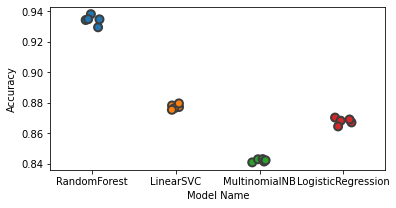

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
sns.stripplot(x='Model Name', y='Accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()